In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

#Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

root="/kaggle/input/poultry-diseases-detection/poultry_diseases"
IMG_SIZE=224

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))
    
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)
    
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))
    
    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)
    
    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path)) 
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]
        
    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()
    
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]
    
    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
def confusion_matrix_plot(y_true, y_pred, figsize=(15,15)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

In [ ]:
augmentation=ImageDataGenerator(
    rescale=1/225.,
    validation_split=0.2,
    vertical_flip=True,
    rotation_range=0.45,
    brightness_range=[0.2,1]
)

train_datagen=augmentation.flow_from_directory(
    root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

test_datagen=augmentation.flow_from_directory(
    root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    subset="validation",
    shuffle=False
)

Found 5451 images belonging to 4 classes.
Found 1361 images belonging to 4 classes.


In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU')
if devices:
    try:
        tf.config.experimental.set_visible_devices(devices, 'GPU')
        for device in devices:
            tf.config.experimental.set_memory_growth(device, True)
    except ValueError as e:
        print(e)

devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model_base=MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE,3),
        include_top=False
    )

    model_base.trainable=False
    inputs=tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x=model_base(inputs)
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dropout(0.2)(x)
    outputs=layers.Dense(4, activation="softmax")(x)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                

In [ ]:
checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

model_history=model.fit(x=train_datagen, 
                        
                        
                        validation_data=test_datagen, 
                        epochs=25,
                        steps_per_epoch=64, 
                        callbacks=[checkpointer, early_stopping])

Epoch 1/25
64/64 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7950
Epoch 1: val_loss improved from inf to 0.41430, saving model to model.hdf5
64/64 [==============================] - 558s 9s/step - loss: 0.5857 - accuracy: 0.7950 - val_loss: 0.4143 - val_accuracy: 0.8472
Epoch 2/25
64/64 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8536
Epoch 2: val_loss improved from 0.41430 to 0.34477, saving model to model.hdf5
64/64 [==============================] - 505s 8s/step - loss: 0.4018 - accuracy: 0.8536 - val_loss: 0.3448 - val_accuracy: 0.8780
Epoch 3/25
64/64 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8753
Epoch 3: val_loss improved from 0.34477 to 0.32461, saving model to model.hdf5
64/64 [==============================] - 507s 8s/step - loss: 0.3347 - accuracy: 0.8753 - val_loss: 0.3246 - val_accuracy: 0.8788
Epoch 4/25
64/64 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8806
E

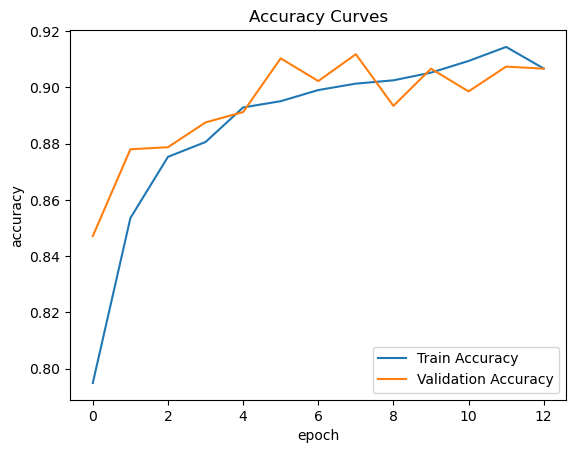

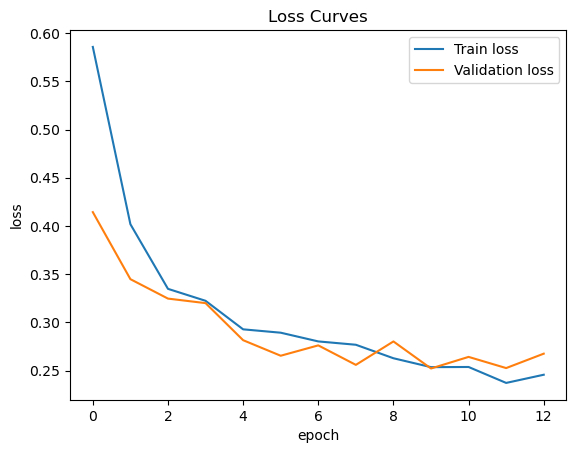

In [ ]:
loss_curve_plot(model_history)

In [ ]:
y_true=test_datagen.classes

y_pred=model.predict(test_datagen)
y_pred=tf.math.round(y_pred).numpy()
y_pred=y_pred.argmax(axis=1)

supervised_metrics(y_true, y_pred)

22/22 [==============================] - 113s 5s/step
Accuracy : 89.12564290962528 %
F1 Score : 0.8890825718056276
Recall : 0.8912564290962528
Precision : 0.892156550270195


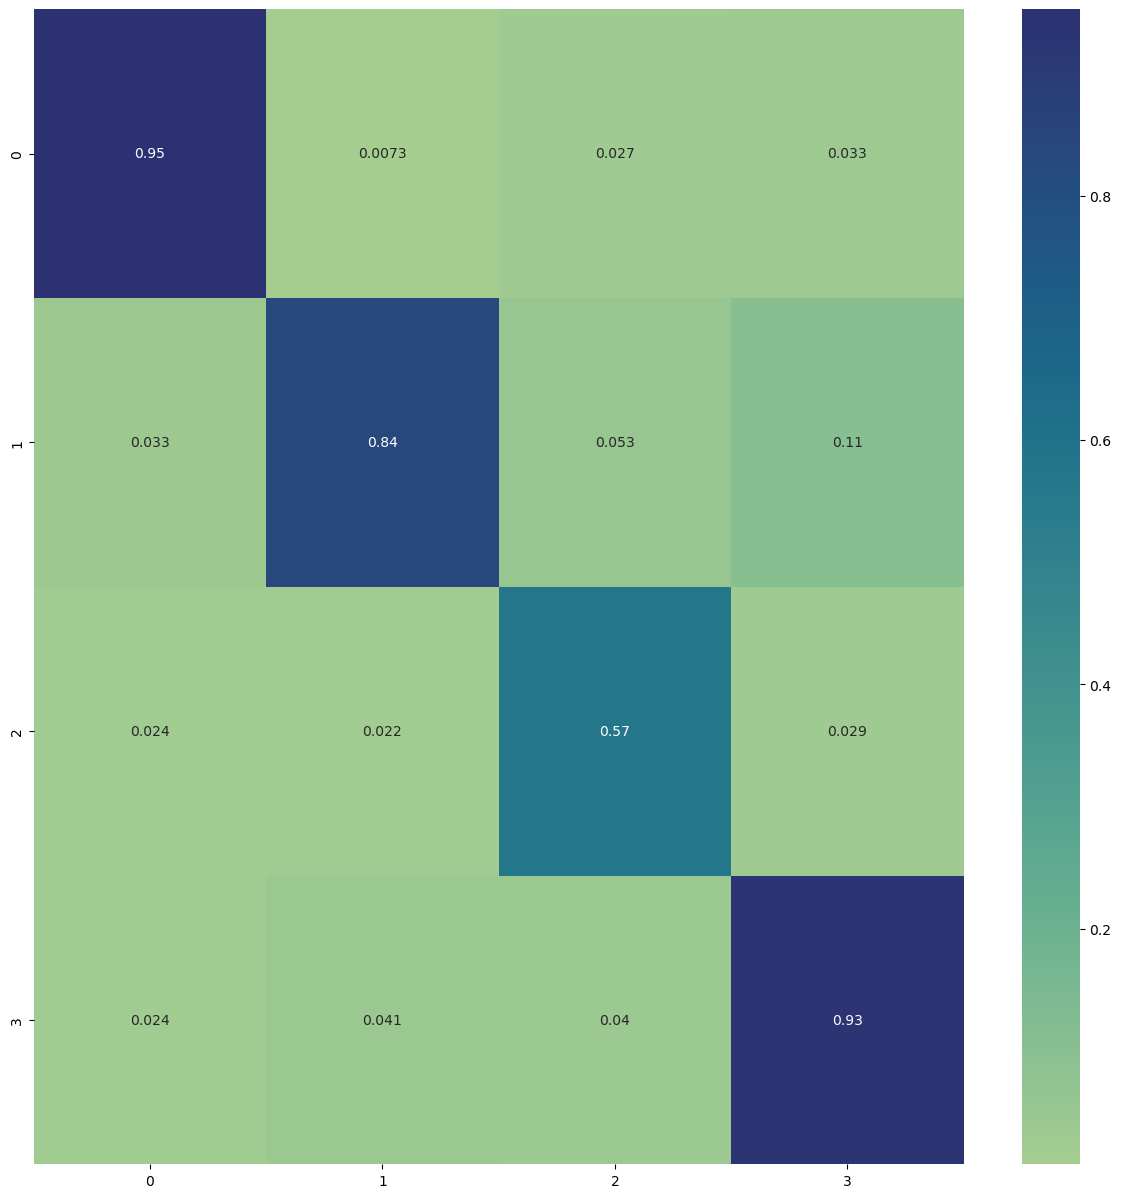

In [ ]:
confusion_matrix_plot(y_true, y_pred)

In [ ]:
!ls

__notebook_source__.ipynb  model.hdf5


In [15]:
model=tf.keras.models.load_model("/content/model.tflite")
path="/content/drive/MyDrive/Colab Notebooks/poultry_diseases"
random_tester(path, ["Cocci", "Healthy", "ncd", "salmo"], model, class_type="muti")

def tflite_
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

OSError: ignored

In [14]:
model.save("/content/drive/MyDrive/Colab Notebooks/model.h5")